In [1]:
import torch 
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('..'))

from pv_plot.plotting import plot_gp, plot_gp_ax, plot_train_test_split
from data import PVDataGenerator, PVDataLoader
from data.utils import *
from models import ApproximateGPBaseModel
from likelihoods.beta import BetaLikelihood_MeanParametrization
from kernels import Kernel

In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 60
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 8
N_SYSTEMS = 300
RADIUS = 0.35
COORDS = (55, -1.5)
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

Predicting 2 hours ahead from 13:00


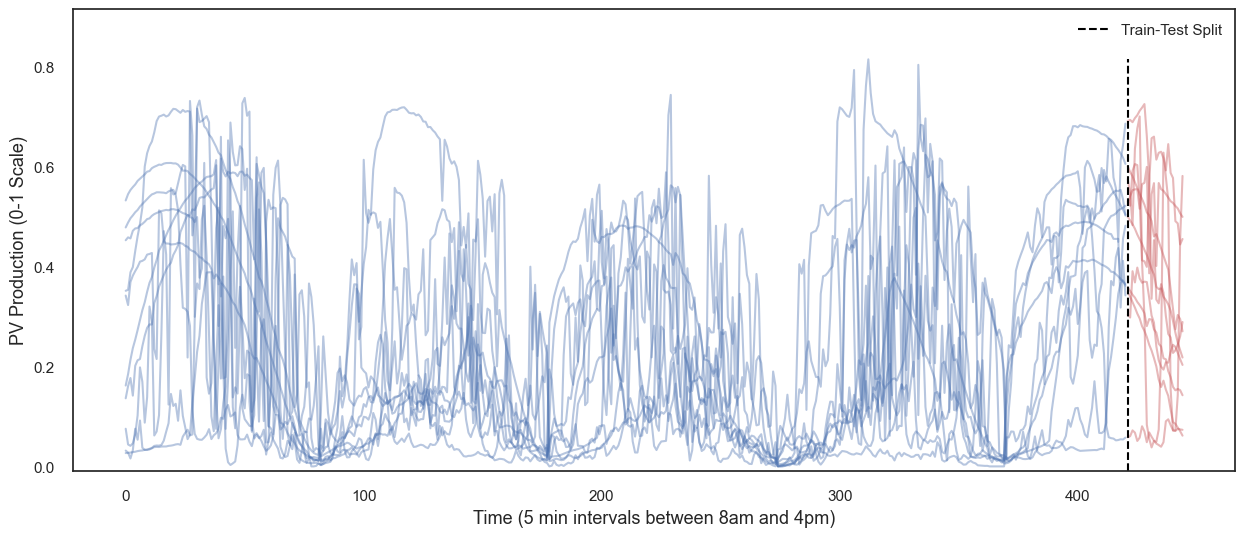

In [3]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    drop_nan=True)
# randomly select 10 systems
X, y = generator.get_time_series()
idx = np.random.choice(y.size(-1) - 1, size=10, replace=False)
y = y[:, idx]

x_train, y_train, x_test, y_test = train_test_split(X, y, hour=13)

plt.rcParams['font.family'] = 'Arial'
plot_train_test_split(y_train, y_test)


In [22]:
np.random.randint(8,14, 1)[0]

11

## Parameters from Hyperparameter Optimization
* alpha_matern      : 8
* beta_matern       : 14
* alpha_periodic    : 8
* beta_periodic     : 10 
* alpha_periodic_P  : 4 
* beta_periodic_P   : 5 
* mean_type         : constant 
* scale             : 1 
* correcting_scale  : 2


In [4]:
from gpytorch.means import ZeroMean
from gpytorch.constraints import Interval, Positive

mean = ZeroMean()

kernel = Kernel()
matern_base = kernel.get_matern(lengthscale_constraint=Positive(),
                                outputscale_constraint=Positive())
matern_quasi = kernel.get_matern(lengthscale_constraint=Interval(0.3, 1000.0),
                                 outputscale_constraint=Positive())
periodic1 = kernel.get_periodic(lengthscale_constraint= Positive(),
                                outputscale_constraint=Positive())
periodic2 = kernel.get_periodic(lengthscale_constraint= Interval(0.1, 1000.0),
                                outputscale_constraint=Positive()
                                )

kernel = kernel.get_quasi_periodic(matern_base=matern_base, 
                                    matern_quasi=matern_quasi,
                                    periodic1=periodic1)

Iter 30/300 - Loss: 0.936
Iter 60/300 - Loss: -0.938
Iter 90/300 - Loss: -1.182
Iter 120/300 - Loss: -1.255
Iter 150/300 - Loss: -1.294
Iter 180/300 - Loss: -1.322
Iter 210/300 - Loss: -1.343
Iter 240/300 - Loss: -1.360
Iter 270/300 - Loss: -1.373
Iter 300/300 - Loss: -1.384
Iter 30/300 - Loss: -0.823
Iter 60/300 - Loss: -1.341
Iter 90/300 - Loss: -1.471
Iter 120/300 - Loss: -1.516
Iter 150/300 - Loss: -1.556
Iter 180/300 - Loss: -1.581
Iter 210/300 - Loss: -1.608
Iter 240/300 - Loss: -1.633
Iter 270/300 - Loss: -1.652
Iter 300/300 - Loss: -1.665
Iter 30/300 - Loss: -0.437
Iter 60/300 - Loss: -0.764
Iter 90/300 - Loss: -0.823
Iter 120/300 - Loss: -0.847
Iter 150/300 - Loss: -0.860
Iter 180/300 - Loss: -0.869
Iter 210/300 - Loss: -0.877
Iter 240/300 - Loss: -0.882
Iter 270/300 - Loss: -0.887
Iter 300/300 - Loss: -0.891
Iter 30/300 - Loss: -0.558
Iter 60/300 - Loss: -0.699
Iter 90/300 - Loss: -0.792
Iter 120/300 - Loss: -0.830
Iter 150/300 - Loss: -0.843
Iter 180/300 - Loss: -0.847
Early

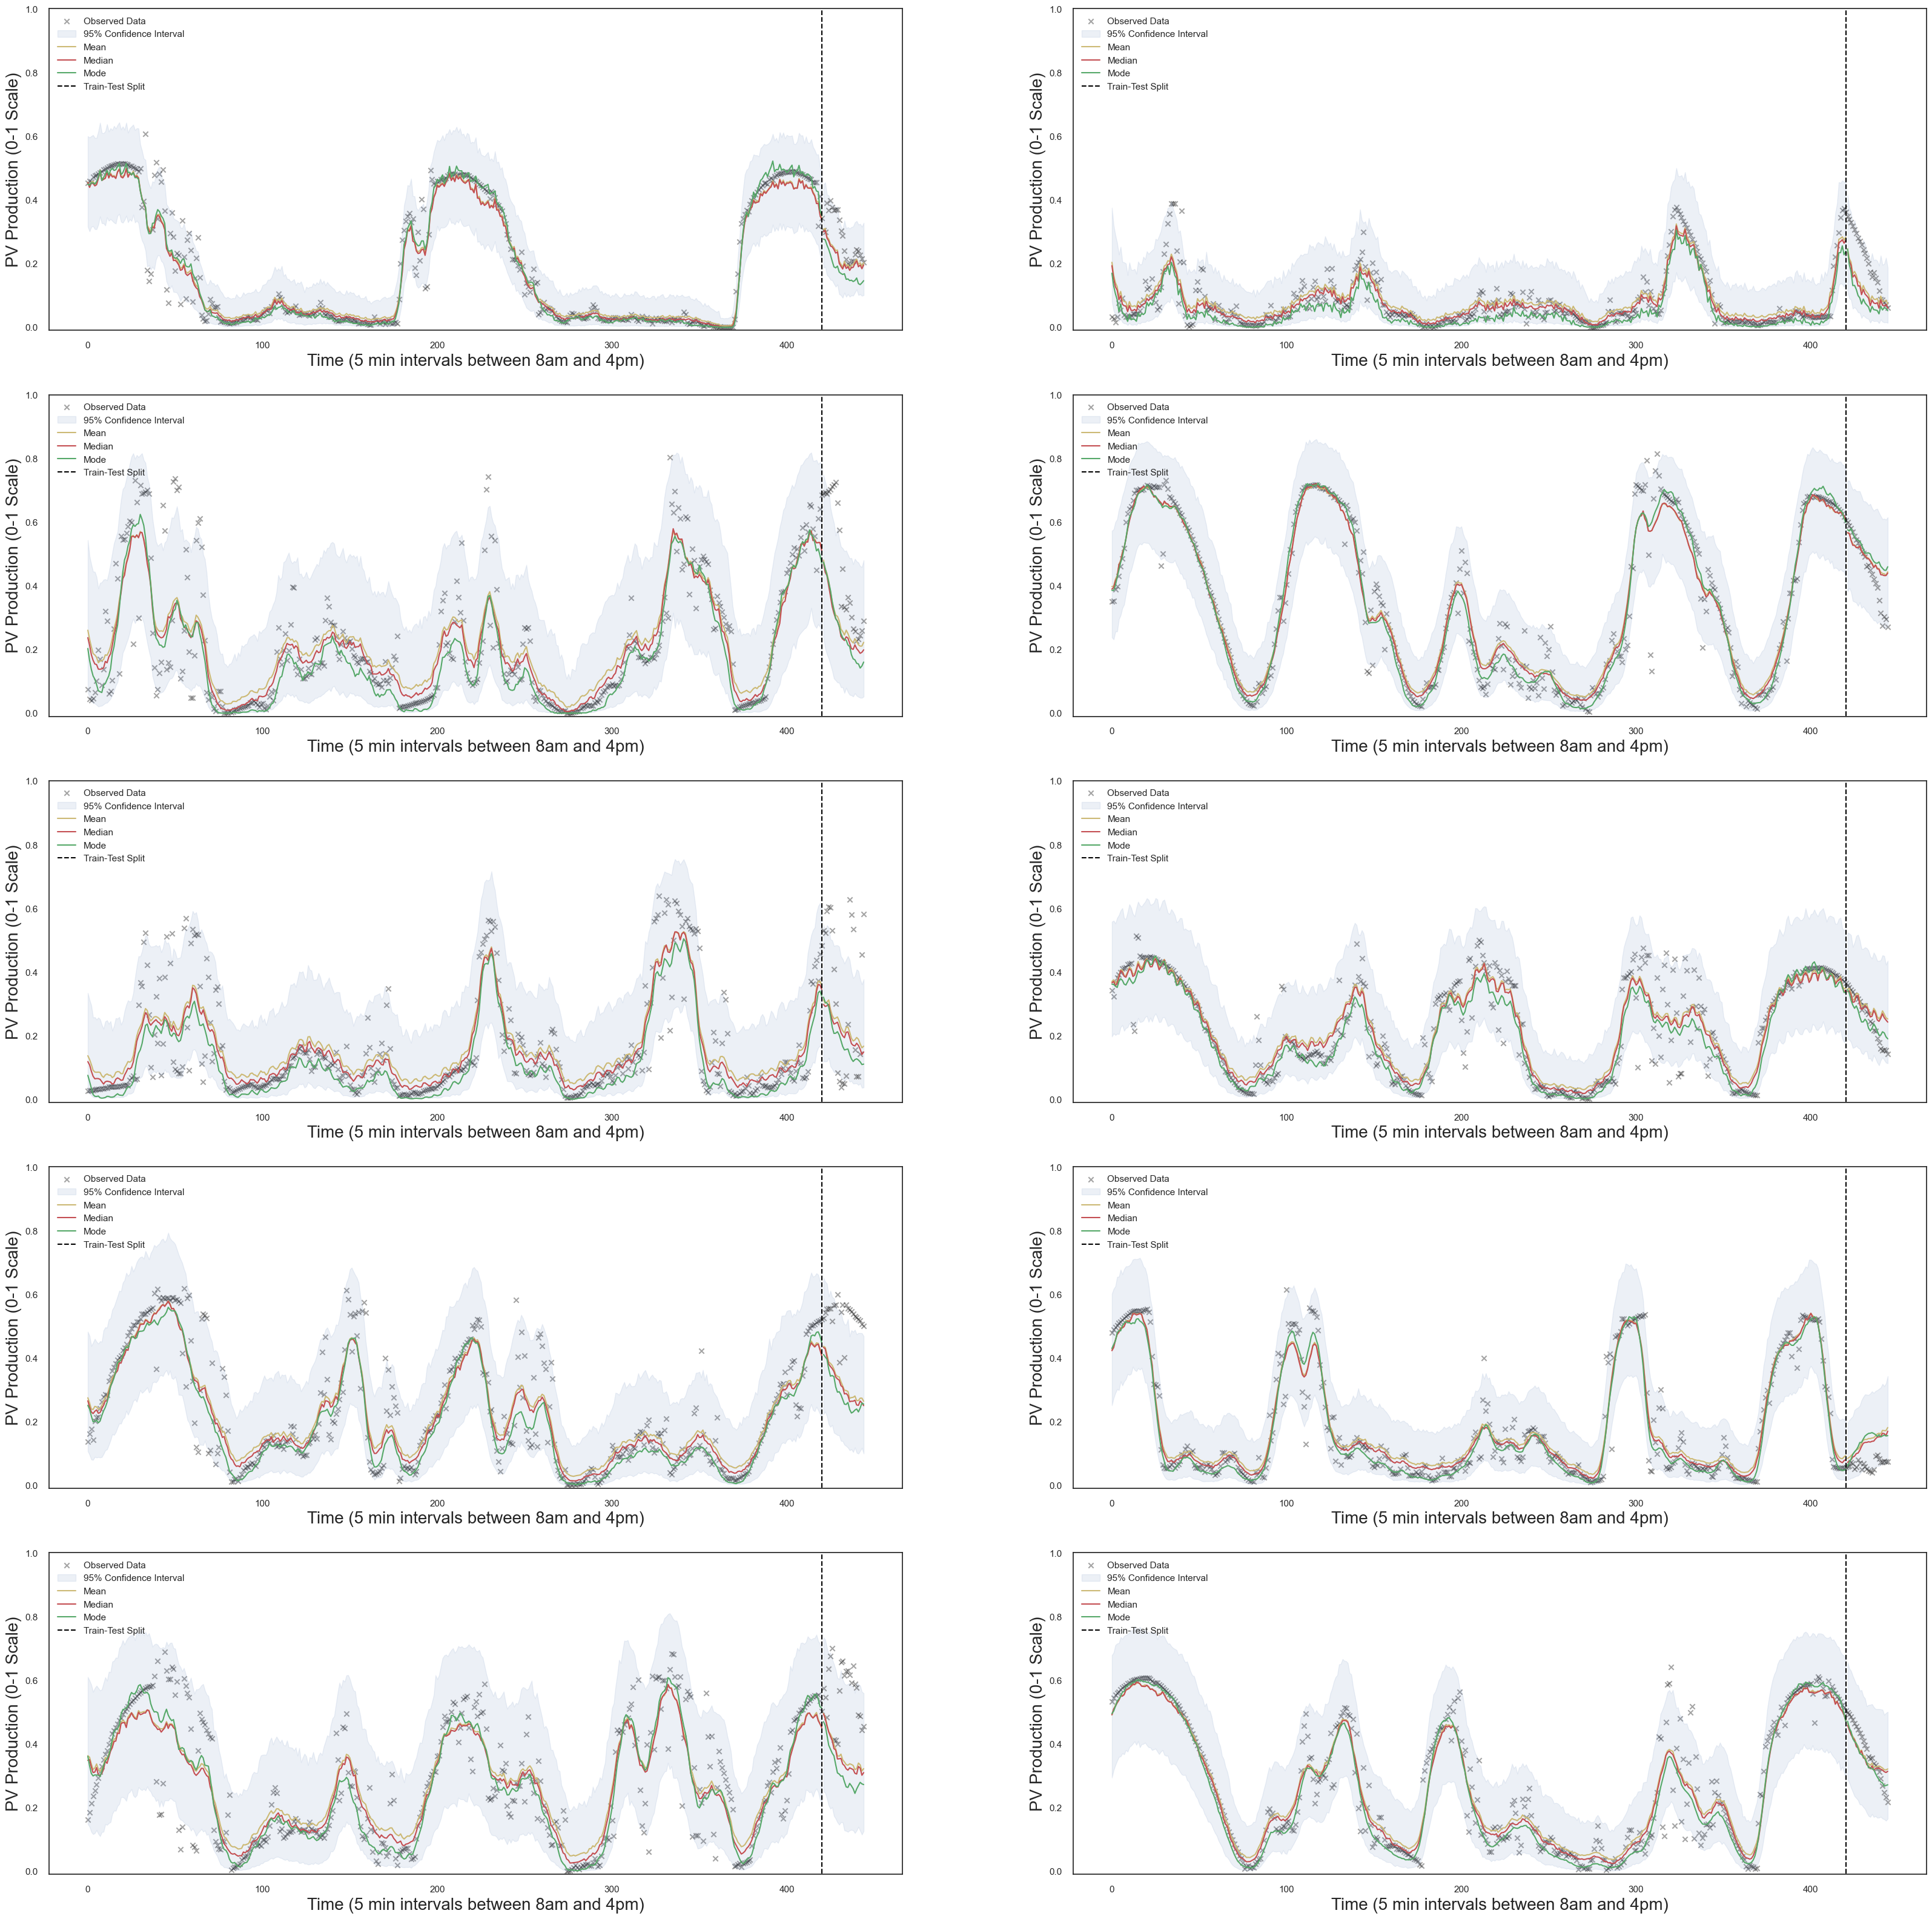

In [5]:
jitter = 1e-3

config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0)
            }
inputs ={
    'X' : x_train,
    'config': config,
    'jitter': jitter,
    'likelihood': BetaLikelihood_MeanParametrization(
                        scale=30,
                        scale_upper_bound=100,
                        scale_lower_bound=1),
    'mean_module': mean,
    'covar_module': kernel,
    'learn_inducing_locations': False
}

n_loops = y_train.size(-1)
fig, axes = plt.subplots(y_train.size(-1) // 2, 2, figsize=(40, 8*n_loops // 2))
axes = axes.flatten()

for idx in range(n_loops):
    inputs['y'] = y_train[:,idx]
    
    model_beta = ApproximateGPBaseModel(**inputs)
    model_beta.fit(n_iter=300, lr=0.05,  verbose=True)  
    preds = model_beta.predict(X)
    plot_gp_ax(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], pred_type='all', ax=axes[idx])


## Testing effect of Dispersion Parameter (scale)

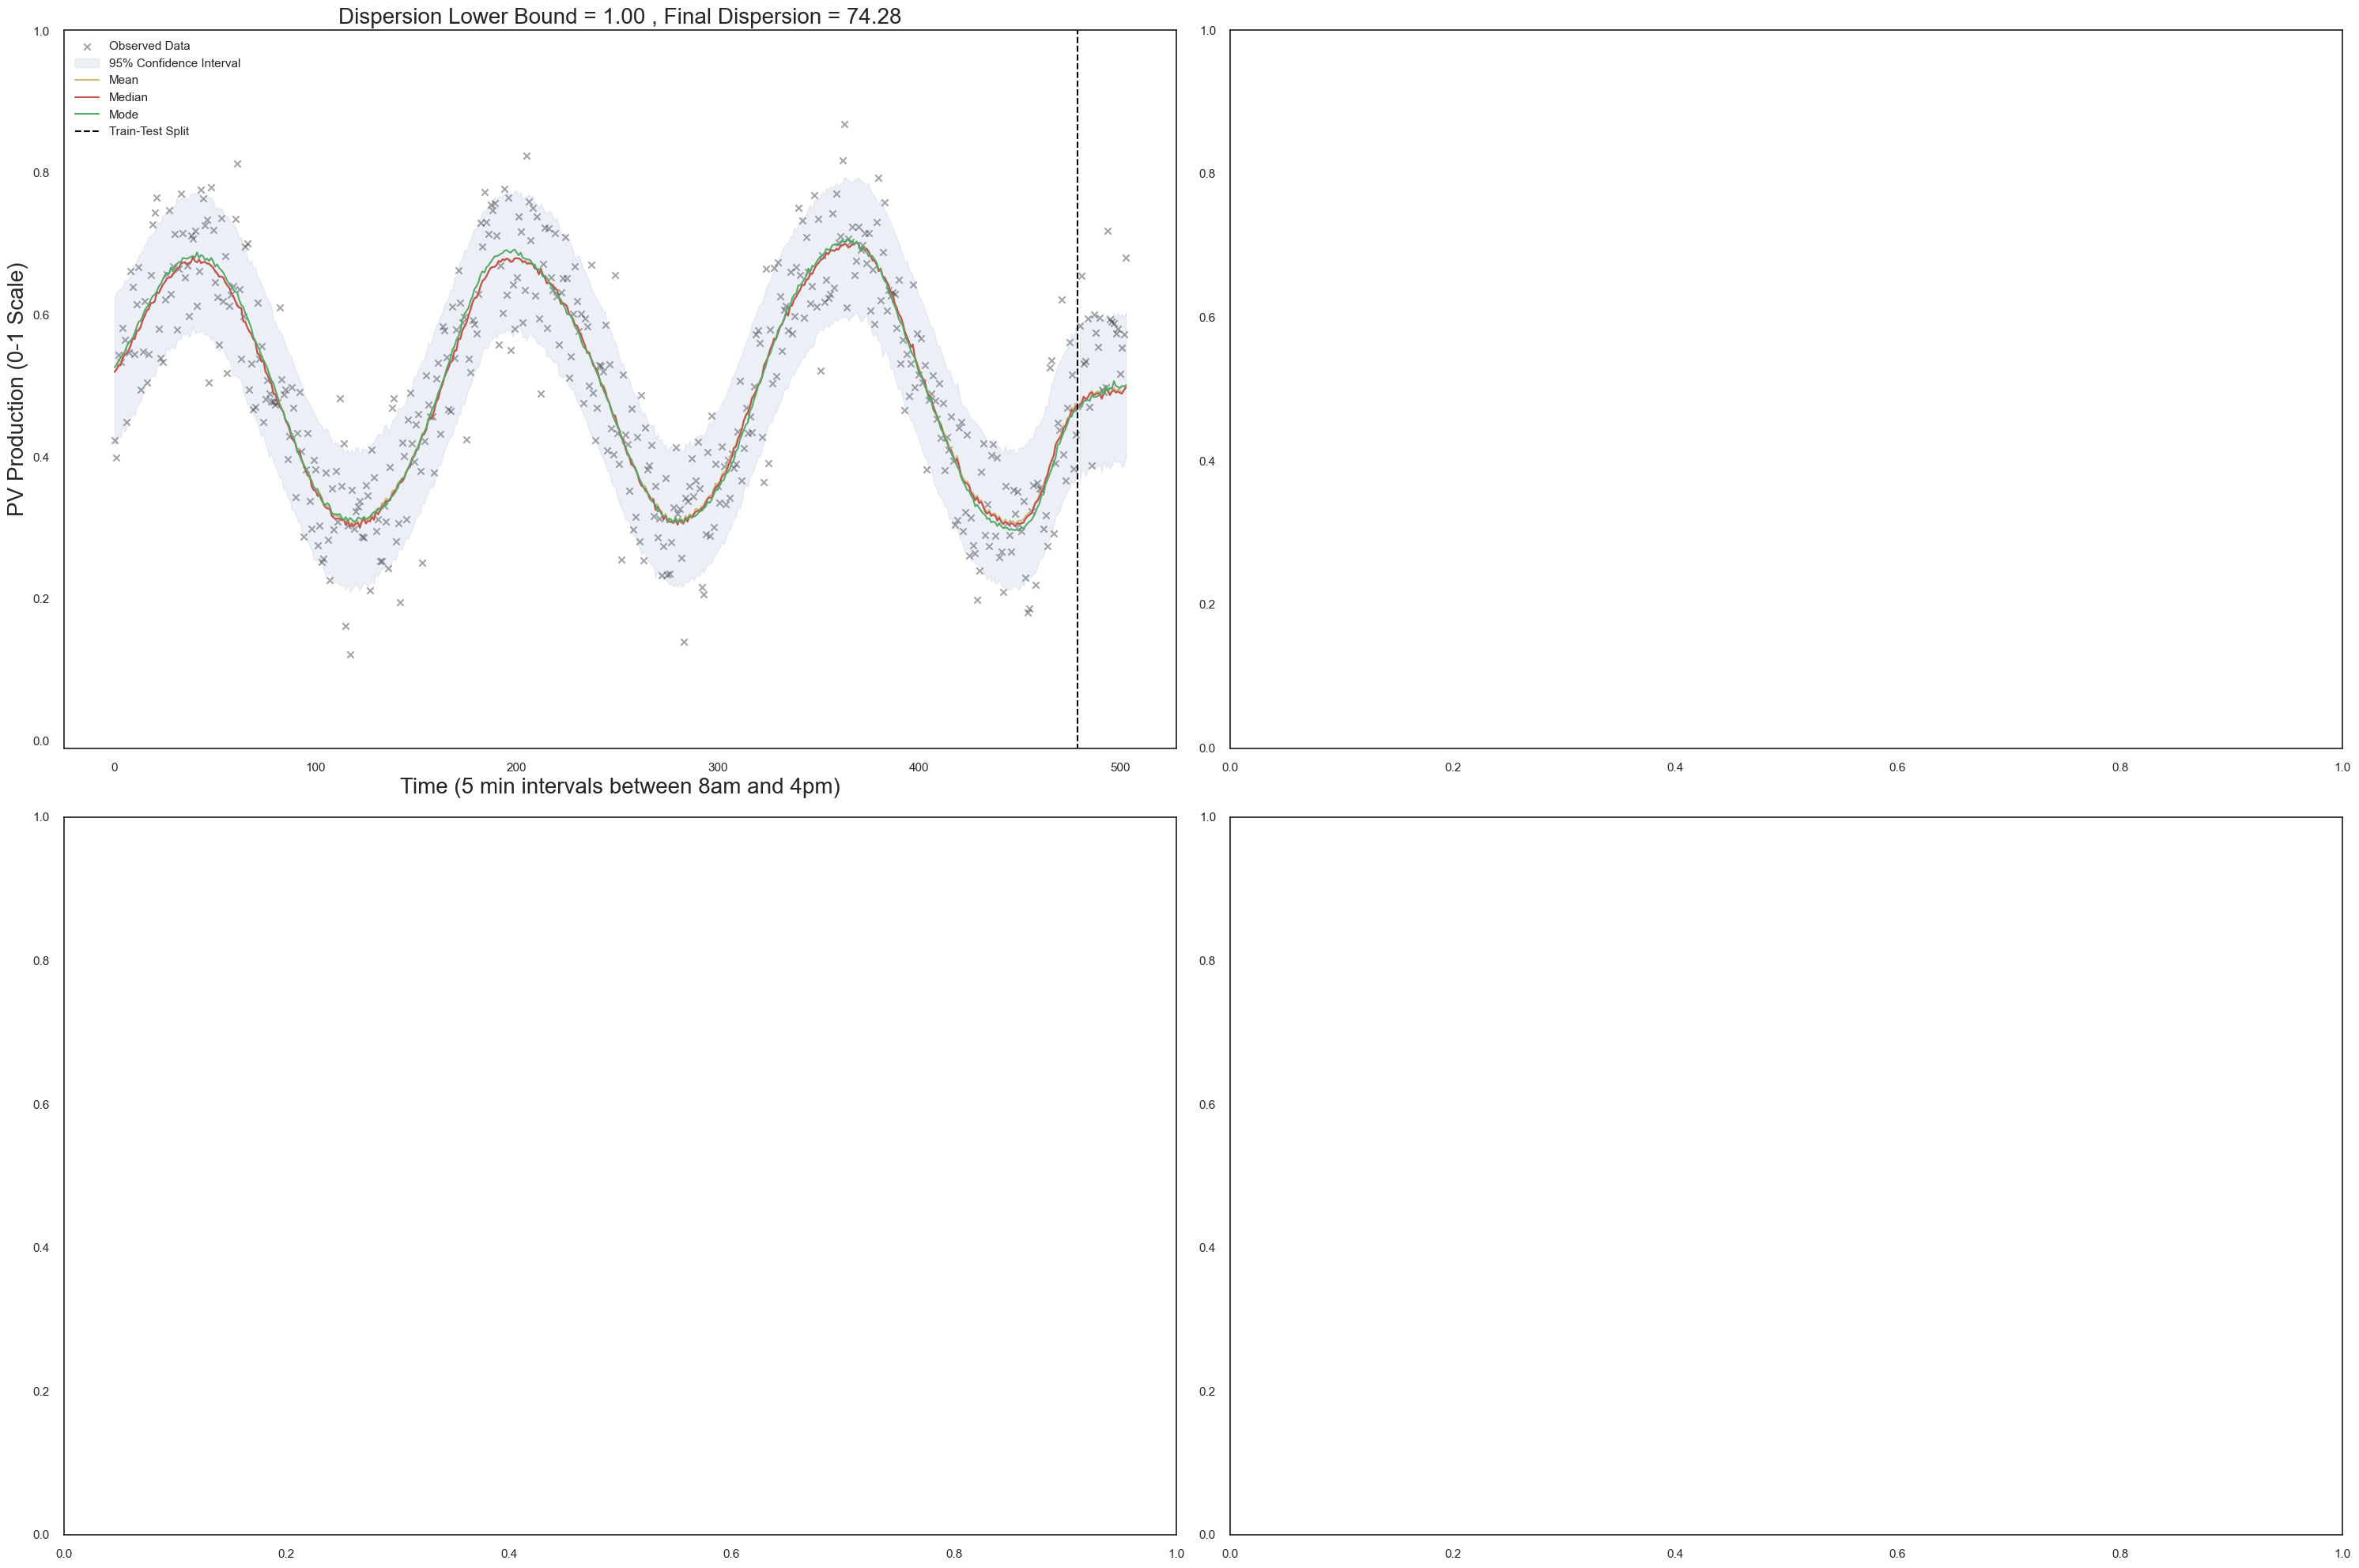

In [10]:
x = torch.linspace(0,100, 400)
hours_pred = 2
hourly_points =  60 // MINUTE_INTERVAL
daily_points = (DAY_MAX - DAY_MIN) * hourly_points
n_points = N_DAYS * daily_points
n_pred = hours_pred * hourly_points 

x = torch.linspace(0, 100, n_points + n_pred)
x_train = x[:n_points]
x_test = x[n_points:]

config['num_inducing_points'] = x_train.size(0)
inputs['config'] = config

y = 0.2*torch.sin(x*torch.pi/(2*8)) + 0.07*torch.randn_like(x) + 0.5
y_train = y[:n_points]
y_test = y[n_points:]

inputs['X'] = x_train
inputs['y'] = y_train

fig, ax = plt.subplots(2, 2, figsize=(30, 20))
axs = ax.flatten()
for i, bound in enumerate([1,]): #100, 200, 1000]):
    
    inputs['likelihood'] = BetaLikelihood_MeanParametrization(scale=bound,
                                                          scale_lower_bound=bound,
                                                          scale_upper_bound=2000)
    model_beta = ApproximateGPBaseModel(**inputs)   
    model_beta.fit(n_iter=100, lr=0.1,  verbose=False)  

    dispersion = f'Dispersion Lower Bound = {model_beta.likelihood.scale_lower_bound:.2f}'
    final_scale = f'Final Dispersion = {model_beta.likelihood.scale.item():.2f}'
    title = dispersion + ' , ' + final_scale

    ax = axs[i]

    plot_gp_ax(model_beta, x_train, x_test, y_train, y_test, title=title, ax=ax, pred_type='all')

plt.tight_layout()
plt.show()


In [17]:
pred_dist = model_beta.predict(x_test)
preds = pred_dist.sample((50,))
lower, upper = np.percentile(preds, [2.5, 97.5], axis=0)
lower, upper = lower.mean(axis=0), upper.mean(axis=0)

# find the percentage of test points that are within the 95% confidence interval

inside = ((y_test.detach().numpy() > lower) & (y_test.detach().numpy() < upper)).sum() / y_test.size(0)

print(f'Percentage of test points within the 95% CI: {inside}')

Percentage of test points within the 95% CI: 0.7083333333333334
